In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
import numpy as np
from GomokuBoard import GomokuBoard
from HeuristicPolicy import Move, StochasticMaxSampler, HeuristicGomokuPolicy, ThreatSearch
from Heuristics import Heuristics
from GomokuTools import GomokuTools as gt

In [4]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

## A sampler
This class allows to sample from the top n of an array of scores, 
with higher probability for the larger scores. With bias > 1.0,
the sampler has an even higher bias toward the larger scores.


In [5]:
sample = np.random.randint(0, 100, [8,8])/20.0
enumerated = list(np.ndenumerate(sample))
sampler = StochasticMaxSampler(enumerated, 10, bias=5)
sampler.choices

[(0.6633168422525413, (4, 4), 0.33668315774745866, 4.9),
 (0.40110773535186806, (2, 3), 0.26220910690067323, 4.85),
 (0.3046463956351851, (5, 3), 0.09646133971668298, 4.65),
 (0.22952222872771583, (7, 3), 0.07512416690746926, 4.6),
 (0.1710154687125918, (6, 7), 0.058506760015124025, 4.55),
 (0.1254503581978424, (7, 5), 0.045565110514749395, 4.5),
 (0.079885247683093, (0, 5), 0.045565110514749395, 4.5),
 (0.044399103933471046, (0, 3), 0.03548614374962196, 4.45),
 (0.016762467393081, (5, 7), 0.027636636540390048, 4.4),
 (0.0, (3, 0), 0.016762467393081, 4.3)]

In [6]:
print([sampler.draw() for i in range(10)])

[(2, 3), (7, 3), (4, 4), (4, 4), (3, 0), (4, 4), (7, 5), (4, 4), (0, 5), (0, 5)]


## Use a policy to play a bit

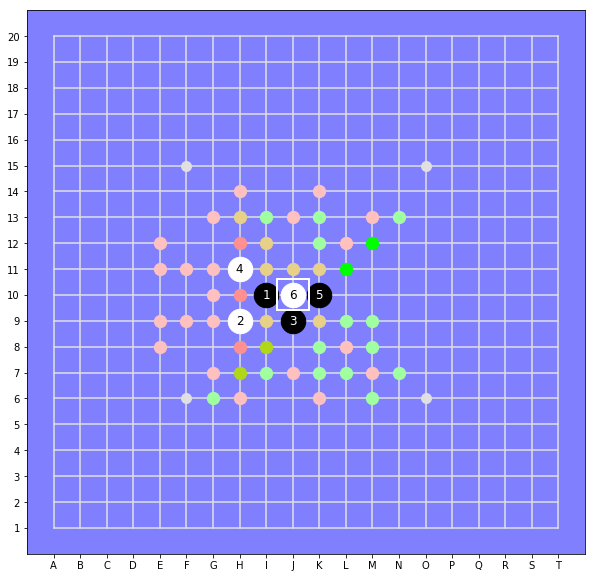

In [8]:
h = Heuristics(kappa=3.0)
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(board, style = 2, bias=.5, topn=5, threat_search=ThreatSearch(5,3))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10)
board.display('current');

CPU times: user 5.68 s, sys: 86.5 ms, total: 5.76 s
Wall time: 5.76 s
Style: 2: (H, 13)
Value after the move: -36.79268187593628


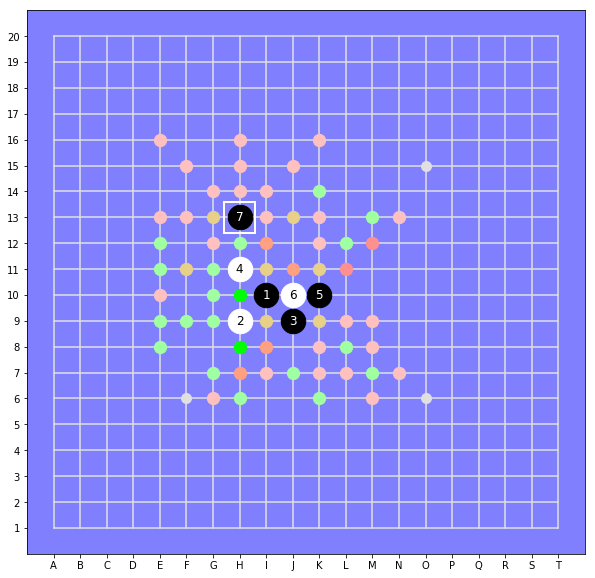

In [11]:
%time move = p.suggest()
print(move)
if move.status == 0:
    board.set(move.x, move.y) 
    print("Value after the move: %s" % board.get_value())
else:
    print("GAME OVER!")
board.display('current')

## Self play

Black 7: - Style: 0: (I, 8)
White 8: - Defending Win-in-2: (H, 7)
Black 9: - Style: 0: (I, 12)
White 10: - Style: 2: (M, 12)
Black 11: - Style: 0: (H, 13)
White 12: - Defending Win-in-2: (J, 11)
Black 13: - Style: 0: (K, 8)
White 14: - Style: 2: (I, 11)
Black 15: - Defending Win-in-2: (G, 11)
White 16: - Style: 2: (L, 7)
Black 17: - Defending lurking threat sequence: (H, 8)
White 18: - Defending Win-in-2: (J, 8)
Black 19: - Style: 0: (E, 16)
White 20: - Style: 2: (K, 7)
Black 21: - Defending lurking threat sequence: (I, 7)
White 22: - Style: 2: (I, 6)
Black 23: - Style: 0: (L, 4)
White 24: - Style: 2: (J, 6)
Black 25: - Defending Soft-win-in-2: (L, 8)
White 26: - Soft-win-in-2: (L, 6)
Black 27: - Defending Win-in-2: (M, 5)
White 28: - Win-in-2: (K, 6)
White wins.


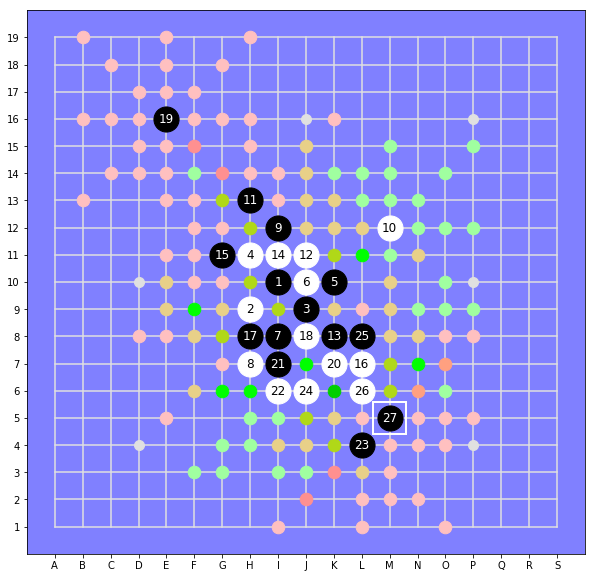

In [26]:
def play_game(options, board, black, white):
    verbose=options['verbose']
    winner = 0
    for _ in range(30):
        move = black.suggest()
        if verbose >= 2:
            print("Black %s: - %s" % (len(board.stones)+1, str(move)))
        if move.status != 0:
            winner = move.status
            break
        # Some strange things do happen!
        elif move.x == 0:
            winner = 0
            break
        board.set(move.x, move.y)
        move = white.suggest()
        if verbose >= 2:
            print("White %s: - %s" % (len(board.stones)+1, str(move)))
        if move.status != 0:
            winner = -move.status
            break
        board.set(move.x, move.y)
    if verbose >= 1:
        print("Black wins." if winner == 1 else "White wins." if winner == -1 else "Not decided yet." )
    return board, gt.stones_to_string(board.stones), winner


game="i10h9j9h11k10j10"
board = GomokuBoard(h, N=19, disp_width=10, stones=gt.string_to_stones(game))
black = HeuristicGomokuPolicy(board, style = 0, bias=0.5, topn=5, threat_search=ThreatSearch(3,3))
white = HeuristicGomokuPolicy(board, style = 2, bias=1.0, topn=5, threat_search=ThreatSearch(2,3))

board, _, _ = play_game({'verbose': 2}, board, black, white)
board.display('current')

In [109]:
game="i10h9j9h11k10j10"
results=[]
for _ in range(100):
    board = GomokuBoard(h, N=19, disp_width=10, stones=gt.string_to_stones(game))
    black = HeuristicGomokuPolicy(board, style = 0, bias=0.5, topn=5, threat_search=ThreatSearch(3,3))
    white = HeuristicGomokuPolicy(board, style = 2, bias=1.0, topn=5, threat_search=ThreatSearch(2,3))
    board, record, status = play_game({'verbose': 1}, board, black, white)
    results.append([record, status])

Black wins.
Black wins.
Black wins.
White wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
White wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
White wins.
Black wins.
Black wins.
Black wins.
White wins.
Black wins.
Black wins.
Black wins.
Black wins.
White wins.
White wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
White wins.
Black wins.
Black wins.
Not decided yet.
Black wins.
Black wins.
Black wins.
Black wins.
White wins.
Black wins.
White wins.
White wins.
White wins.
Black wins.
Black wins.
Black wins.
Black wins.
Not decided yet.
White wins.
Black wins.
Black wins.
White wins.
Black wins.
Black wins.
Black wins.
Black wins.
White wins.
Black wins.
Black wins.
White wins.
Black wins.
Black wins.
Black wins.
Black wins.
Black wins.
White wins.
White wins.
Black wins.
Black wins.
Black 

In [110]:
import pandas as pd
df = pd.DataFrame(results)
df.columns=['game', 'winner']
df.to_csv("self_play_games-6.csv", index=None)

In [111]:
df.head()

,game,winner
0,i10h9j9h11k10j10m6m12l7k8l6n6k6h7m8n9l9j11,1
1,i10h9j9h11k10j10g6m12k9m9k7k8h6i6h7i8i7j8,1
2,i10h9j9h11k10j10g6m12k9m9l7k8h6j6i8h7i7j8,1
3,i10h9j9h11k10j10l9l11i12j11i11i9h8i8n7i14g9i7f...,-1
4,i10h9j9h11k10j10g6m12k9k8n9m8h6i6i7j8l8h5j7h7g...,1


In [112]:
df1 = pd.read_csv("self_play_games-1.csv")
df2 = pd.read_csv("self_play_games-2.csv")
df3 = pd.read_csv("self_play_games-3.csv")
df4 = pd.read_csv("self_play_games-4.csv")
df5 = pd.read_csv("self_play_games-5.csv")
df6 = pd.read_csv("self_play_games-6.csv")

In [113]:
dfm = df1.append(df2).append(df3).append(df4).append(df5).append(df6)
dfm.count()

game      500
winner    500
dtype: int64

In [102]:
dfm[dfm['winner']==-1].count()

game      85
winner    85
dtype: int64